In [273]:
from bintrees import FastRBTree as RBTree
import random
from matplotlib import pyplot as plt
import numpy as np
import time

# Q-digest

### Algorithm implementation

In [274]:
class Centroid:
    # Класс для хранения центроида
    def __init__(self, mean, n, cumn):
        # mean: среднее значение центроида
        # n: количество элементов в центроиде
        # cumn: кумулятивное количество элементов до этого центроида
        self.mean = float(mean)
        self.n = n
        self.cumn = cumn


class Qdigest:
    # Класс для T-Digest

    def __init__(self, delta=0.01, k=25, cx=1.1):
        # delta: максимальная ошибка при вычислении перцентилей
        # k: максимальное количество центроидов до сжатия данных
        # cx: коэффициент сжатия данных
        self.n = None
        self.compressing = None
        self.last_cumulate = None
        self.delta = delta
        self.K = k
        self.CX = cx
        self.centroids = RBTree()
        self.nreset = 0
        self.reset()

    def reset(self):
        # Сбросить T-Digest
        self.centroids.clear()
        self.n = 0
        self.nreset += 1
        self.last_cumulate = 0
        self.compressing = False

    def add(self, x, n=1):
        # Добавить новое значение в T-Digest
        if not isinstance(x, list):
            x = [x]
        for item in x:
            self._digest(item, n)

    def percentile(self, p):
        # Вычислить перцентиль
        if self.size() == 0:
            return None
        self._cumulate(True)
        cumn = self.n * p
        lower = self.centroids.min_item()[1]
        upper = self.centroids.max_item()[1]
        for c in self.centroids.values():
            if c.cumn <= cumn:
                lower = c
            else:
                upper = c
                break
        if lower == upper:
            return lower.mean
        return lower.mean + (cumn - lower.cumn) * (upper.mean - lower.mean) / \
            (upper.cumn - lower.cumn)

    def _digest(self, x, n):
        # Добавить новое значение в T-Digest
        if self.size() == 0:
            self._new_centroid(x, n, 0)
        else:
            _min = self.centroids.min_item()[1]
            _max = self.centroids.max_item()[1]
            nearest = self.find_nearest(x)
            if nearest and nearest.mean == x:
                self._addweight(nearest, x, n)
            elif nearest == _min:
                self._new_centroid(x, n, 0)
            elif nearest == _max:
                self._new_centroid(x, n, self.n)
            else:
                p = (nearest.cumn + nearest.n / 2.0) / self.n
                max_n = int(4 * self.n * self.delta * p * (1 - p))
                if max_n >= nearest.n + n:
                    self._addweight(nearest, x, n)
                else:
                    self._new_centroid(x, n, nearest.cumn)
        self._cumulate(False)
        if self.K and self.size() > self.K / self.delta:
            self.compress()

    def find_nearest(self, x):
        # Найти ближайший центроид к заданному значению
        if self.size() == 0:
            return None
        try:
            lower = self.centroids.ceiling_item(x)[1]
        except KeyError:
            lower = None

        if lower and lower.mean == x:
            return lower

        try:
            prev = self.centroids.floor_item(x)[1]
        except KeyError:
            prev = None

        if not lower:
            return prev
        if not prev:
            return lower
        if abs(prev.mean - x) < abs(lower.mean - x):
            return prev
        else:
            return lower

    def size(self):
        # Получить количество центроидов в T-Digest
        return len(self.centroids)

    def compress(self):
        # Сжать данные в T-Digest
        if self.compressing:
            return
        points = self.to_list()
        self.reset()
        self.compressing = True
        for point in sorted(points, key=lambda x: random.random()):
            self.add(point['mean'], point['n'])
        self._cumulate(True)
        self.compressing = False

    def _cumulate(self, exact):
        # Функция для накопления суммы весов всех центроидов
        # Если количество элементов не изменилось, то ничего не делаем
        if self.n == self.last_cumulate:
            return
        # Если необходимо вычислить точное значение, то проверяем условие
        # Если CX > (n / last_cumulate), то ничего не делаем
        if not exact and self.CX and self.last_cumulate and self.CX > (self.n / self.last_cumulate):
            return
        # Накапливаем сумму весов всех центроидов
        cumn = 0
        for c in self.centroids.values():
            cumn = c.cumn = cumn + c.n
        self.n = self.last_cumulate = cumn

    def to_list(self):
        # Функция для преобразования центроидов в список словарей
        return [dict(mean=c.mean, n=c.n, cumn=c.cumn) for
                c in self.centroids.values()]

    def _addweight(self, nearest, x, n):
        # Функция для добавления веса к ближайшему центроиду
        # Если x не равен среднему значению ближайшего центроида, то обновляем его значение
        if x != nearest.mean:
            nearest.mean += n * (x - nearest.mean) / (nearest.n + n)
        # Накапливаем сумму весов ближайшего центроида
        nearest.cumn += n
        # Увеличиваем количество элементов ближайшего центроида на n
        nearest.n += n
        # Увеличиваем общее количество элементов на n
        self.n += n

    def _new_centroid(self, x, n, cumn):
        # Функция для создания нового центроида.
        # Создаем новый центроид с заданными параметрами
        c = Centroid(x, n, cumn)
        # Добавляем новый центроид в словарь центроидов
        self.centroids.insert(x, c)
        # Увеличиваем общее количество элементов на n
        self.n += n
        return c


### Function for comparing the results of the `Q-Digest` and the `numpy.percentile` function

In [275]:
def compare(data_to_test: list, percentiles: list, log: bool = False):
    # Функция для сравнения q-digest и numpy
    print(f'Comparing q-digest to numpy. Datasize: {len(data_to_test)}')
    # Создаем новый объект Tdigest
    q_digest = Qdigest()
    # Добавляем каждый элемент из data_to_test в Tdigest
    for i in data_to_test:
        q_digest.add(i)
    # Вычисляем перцентили для q-digest и numpy
    q_digest_percentiles = [q_digest.percentile(percentile) for percentile in percentiles]
    np_percentiles = [np.percentile(data_to_test, percentile * 100) for percentile in percentiles]
    differences = [abs(q_digest_percentiles[i] - np_percentiles[i]) for i in range(len(percentiles))]

    # Сравниваем значения перцентилей для q-digest и numpy
    for i in range(len(percentiles)):
        q_digest_val = q_digest_percentiles[i]
        np_val = np_percentiles[i]
        if log:
            print(
                f'q-digest {percentiles[i]}: {q_digest_val}, numpy {percentiles[i]}: {np_val},'
                f' difference: {differences[i]:.5f}')

    return q_digest_percentiles, np_percentiles, differences


def compare_and_draw(data_to_test: list, percentiles: list, log: bool = True):
    q_digest_percentiles, np_percentiles, differences = compare(data_to_test, percentiles, log)
    # Создаем график
    x = np.arange(len(data_to_test))
    plt.plot(x, data_to_test, color='b', alpha=0.5)
    plt.xlabel('Индекс элемента')
    plt.ylabel('Значение элемента')

    # Добавляем горизонтальные линии на график
    q_lines = [plt.axhline(y=percentile, color='r', linestyle='-') for percentile in q_digest_percentiles]
    np_lines = [plt.axhline(y=percentile, color='g', linestyle='--') for percentile in np_percentiles]

    # Добавляем значения на график
    for i in range(len(q_lines)):
        plt.text(0, q_digest_percentiles[i], f'{q_digest_percentiles[i]:.2f}', color='r', fontsize=10, ha='right')
        plt.text(0, np_percentiles[i], f'{np_percentiles[i]:.2f}', color='g', fontsize=10, ha='left')
    # Добавляем легенду на график
    plt.legend([q_lines[0], np_lines[0]], ['q-digest', 'numpy'], shadow=True, fancybox=True, loc="upper right")
    # Отображаем график
    plt.show()

### Testing the `Q-Digest` implementation, comparing it to the `numpy.percentile` function

In [276]:
quantiles_to_test = [0.25, 0.5, 0.75]

#### Нормальное распределение

Comparing q-digest to numpy. Datasize: 1000
q-digest 0.25: -59.02747694313852, numpy 0.25: -58.737248770847486, difference: 0.29023
q-digest 0.5: 2.6748156446743567, numpy 0.5: 3.2351336546493608, difference: 0.56032
q-digest 0.75: 72.70490138605477, numpy 0.75: 72.85989408005192, difference: 0.15499


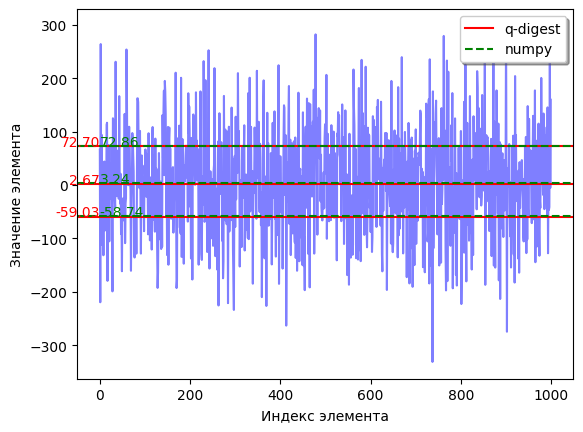

In [277]:
data = np.random.normal(0, 100, 1000)
compare_and_draw(data, quantiles_to_test)

#### Равномерное распределение

Comparing q-digest to numpy. Datasize: 1000
q-digest 0.25: 26.46256918013315, numpy 0.25: 27.027224097542458, difference: 0.56465
q-digest 0.5: 51.93082654122452, numpy 0.5: 52.11930783731101, difference: 0.18848
q-digest 0.75: 75.52269041644766, numpy 0.75: 75.62679635743136, difference: 0.10411


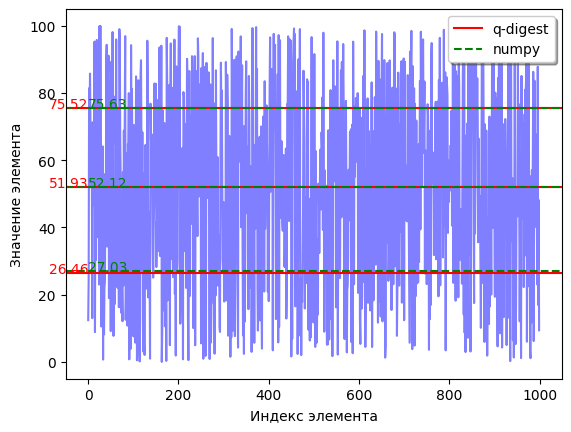

In [278]:
data = np.random.uniform(0, 100, 1000)
compare_and_draw(data, quantiles_to_test)

#### Экспоненциальное распределение

Comparing q-digest to numpy. Datasize: 1000
q-digest 0.25: 29.532811778623234, numpy 0.25: 29.6310352983946, difference: 0.09822
q-digest 0.5: 70.85197865304302, numpy 0.5: 71.12503635709427, difference: 0.27306
q-digest 0.75: 139.34286185442613, numpy 0.75: 139.44004841874028, difference: 0.09719


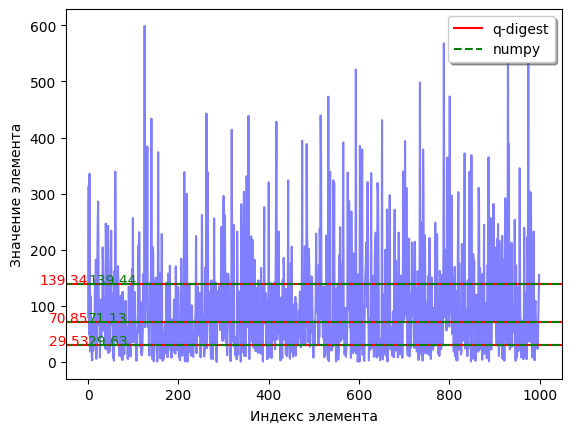

In [279]:
data = np.random.exponential(100, 1000)
compare_and_draw(data, quantiles_to_test)

#### Временные ряды

Можно сгенерировать временной ряд, например, синусоиду с шумом. Это позволит проверить, как алгоритм работает с данными, которые имеют временную зависимость.

Comparing q-digest to numpy. Datasize: 1000
q-digest 0.25: -0.39669677975531864, numpy 0.25: -0.3889976098279333, difference: 0.00770
q-digest 0.5: 0.30338310276807956, numpy 0.5: 0.30489832544327766, difference: 0.00152
q-digest 0.75: 0.7889916392022808, numpy 0.75: 0.7918604562408139, difference: 0.00287


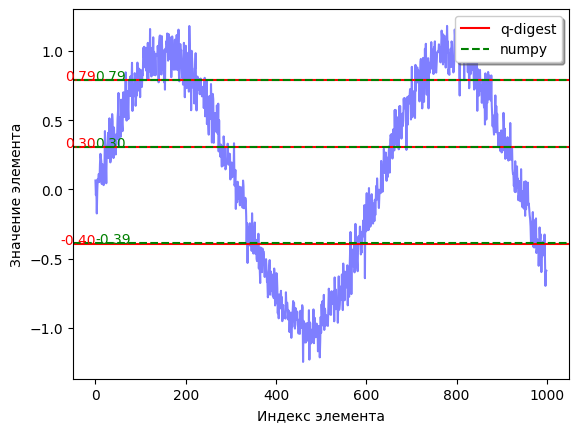

In [280]:
# Генерируем временной ряд
t = np.linspace(0, 10, 1000)
data = np.sin(t) + np.random.normal(loc=0, scale=0.1, size=1000)
compare_and_draw(data, quantiles_to_test)

#### Тест на небольших наборах данных

##### Размер данных 10

Comparing q-digest to numpy. Datasize: 10
q-digest 0.25: -139.96106241601768, numpy 0.25: -122.15533132715971, difference: 17.80573
q-digest 0.5: -23.521874372409908, numpy 0.5: -9.713686540126535, difference: 13.80819
q-digest 0.75: 55.58634564516787, numpy 0.75: 58.47112317687059, difference: 2.88478


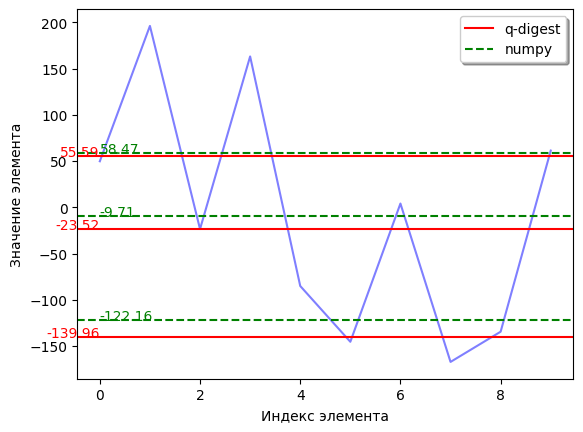

In [281]:
data = np.random.normal(0, 100, 10)
compare_and_draw(data, quantiles_to_test)

##### Размер данных 50

Comparing q-digest to numpy. Datasize: 50
q-digest 0.25: -91.87976250938483, numpy 0.25: -85.41874127706376, difference: 6.46102
q-digest 0.5: -33.27143102995972, numpy 0.5: -26.49199436708941, difference: 6.77944
q-digest 0.75: 57.30009750317214, numpy 0.75: 57.43161920223086, difference: 0.13152


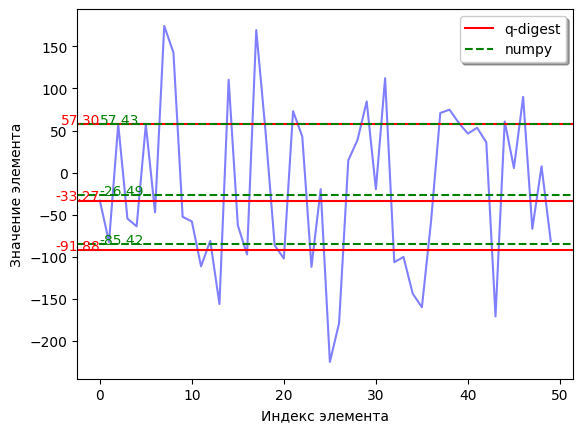

In [282]:
data = np.random.normal(0, 100, 50)
compare_and_draw(data, quantiles_to_test)

##### Размер данных 100

Comparing q-digest to numpy. Datasize: 100
q-digest 0.25: -79.57048556789914, numpy 0.25: -75.20225191819786, difference: 4.36823
q-digest 0.5: -11.436497824259408, numpy 0.5: -9.349841083963813, difference: 2.08666
q-digest 0.75: 69.5972395102508, numpy 0.75: 69.75142570583125, difference: 0.15419


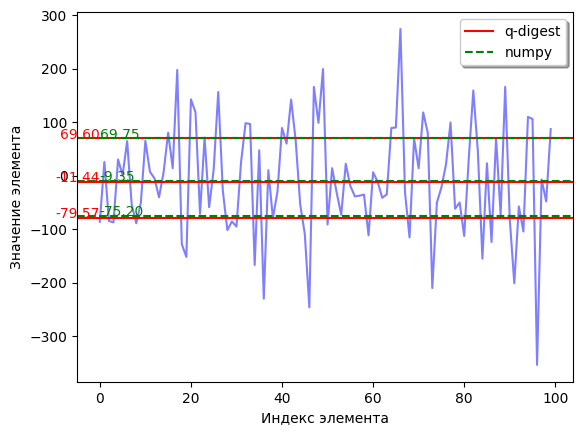

In [283]:
data = np.random.normal(0, 100, 100)
compare_and_draw(data, quantiles_to_test)

#### График разниц для разных размеров данных

In [284]:

data_sizes = np.arange(10, 1000, 1)

differences = []

for data_size in data_sizes:
    data = np.random.normal(0, 100, data_size)
    q_digest_percentiles, np_percentiles, differences_by_quantile = compare(data, quantiles_to_test, log=False)
    differences_mean = np.mean(differences_by_quantile)
    differences.append(differences_mean)



Comparing q-digest to numpy. Datasize: 10
Comparing q-digest to numpy. Datasize: 11
Comparing q-digest to numpy. Datasize: 12
Comparing q-digest to numpy. Datasize: 13
Comparing q-digest to numpy. Datasize: 14
Comparing q-digest to numpy. Datasize: 15
Comparing q-digest to numpy. Datasize: 16
Comparing q-digest to numpy. Datasize: 17
Comparing q-digest to numpy. Datasize: 18
Comparing q-digest to numpy. Datasize: 19
Comparing q-digest to numpy. Datasize: 20
Comparing q-digest to numpy. Datasize: 21
Comparing q-digest to numpy. Datasize: 22
Comparing q-digest to numpy. Datasize: 23
Comparing q-digest to numpy. Datasize: 24
Comparing q-digest to numpy. Datasize: 25
Comparing q-digest to numpy. Datasize: 26
Comparing q-digest to numpy. Datasize: 27
Comparing q-digest to numpy. Datasize: 28
Comparing q-digest to numpy. Datasize: 29
Comparing q-digest to numpy. Datasize: 30
Comparing q-digest to numpy. Datasize: 31
Comparing q-digest to numpy. Datasize: 32
Comparing q-digest to numpy. Datas

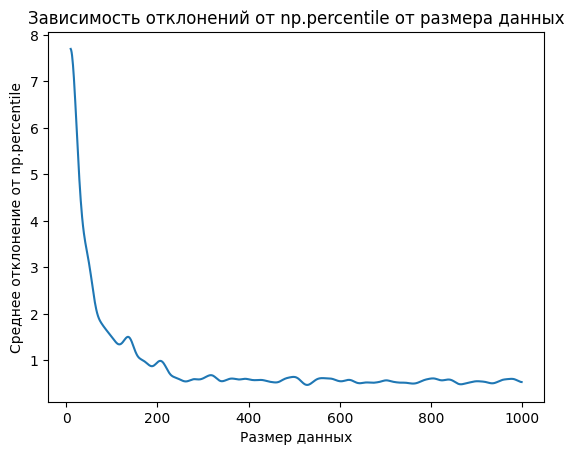

In [285]:
from scipy.ndimage import gaussian_filter1d
smoothed_differences = gaussian_filter1d(differences, sigma=10)

plt.plot(data_sizes, smoothed_differences)
plt.title('Зависимость отклонений от np.percentile от размера данных')
plt.xlabel('Размер данных')
plt.ylabel('Среднее отклонение от np.percentile')
plt.show()

### Оценка времени работы алгоритма
Нужно построить график зависимости затрат памяти алгоритма от размера входных данных


In [286]:
def get_25_percentile(data):
    q_digest = Qdigest()
    for i in data:
        q_digest.add(i)
    return q_digest.percentile(0.25)

In [287]:
data_sizes = np.concatenate([np.arange(1, 3000, 1)])

In [288]:
# Создаем список для хранения времени работы алгоритма
times = []

# измерение времени работы и затрат по памяти алгоритма для каждого размера входных данных
for data_size in data_sizes:
    # Генерируем данные равномерного распределения
    data = np.random.uniform(0, 100, data_size)
    # Запускаем таймер
    start_time = time.time()
    # Создаем новый объект Tdigest
    get_25_percentile(data)
    # Останавливаем таймер
    end_time = time.time()
    # Вычисляем время работы алгоритма
    time_elapsed = end_time - start_time
    # Добавляем время работы алгоритма в список
    times.append(time_elapsed)
    print(f'Размер входных данных: {data_size}, время работы алгоритма: {time_elapsed:.10f} секунд')




Размер входных данных: 1, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 2, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 3, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 4, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 5, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 6, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 7, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 8, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 9, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 10, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 11, время работы алгоритма: 0.0010380745 секунд
Размер входных данных: 12, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 13, время работы алгоритма: 0.0000000000 секунд
Размер входных данных: 14, время работы алгоритма: 0.0000000000 секунд
Размер входных 

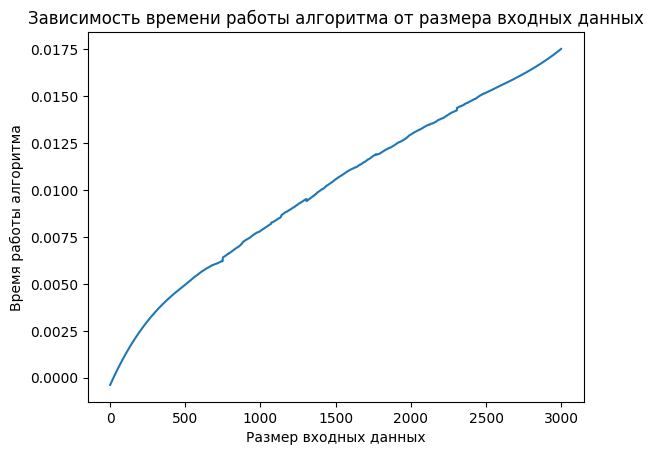

In [289]:
from scipy.signal import savgol_filter

# преобразуем список в numpy array
times = np.array(times)
# фильтруем данные фильтром Савицкого-Голэй, чтобы убрать выбросы и визуально сгладить график
filtered_times = savgol_filter(times, 1000, 3)
# строим график зависимости времени работы алгоритма от размера входных данных
plt.plot(data_sizes, filtered_times)
plt.title('Зависимость времени работы алгоритма от размера входных данных')
plt.xlabel('Размер входных данных')
plt.ylabel('Время работы алгоритма')
plt.show()

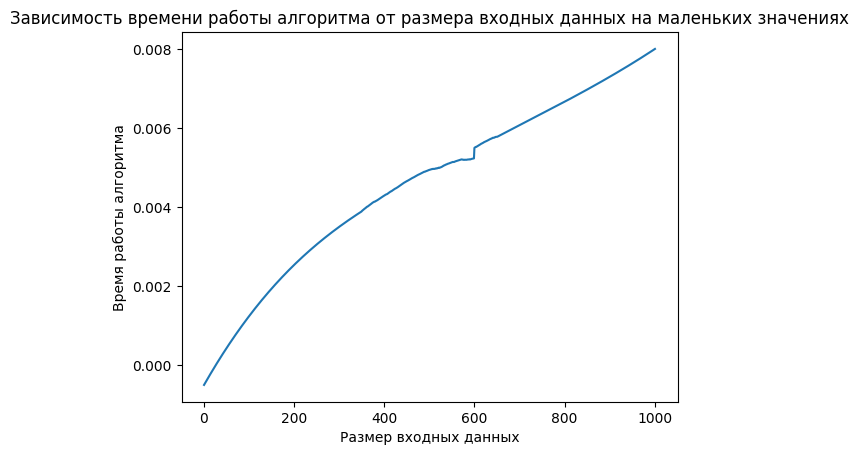

In [290]:
# рассмотрим график на маленьких значениях входных данных
small_times = times[:1000]
filtered_small_times = savgol_filter(small_times, 700, 3)
plt.plot(data_sizes[:1000], filtered_small_times)
plt.title('Зависимость времени работы алгоритма от размера входных данных на маленьких значениях')
plt.xlabel('Размер входных данных')
plt.ylabel('Время работы алгоритма')
plt.show()

## Отчет

**Q-digest** - это алгоритм аппроксимации квантилей, который позволяет вычислять различные статистические показатели на больших объемах данных. Он основан на идеях алгоритма "счетчиков" и использует древовидную структуру данных для эффективного хранения и обработки информации.

**Основная идея** Q-Digest заключается в том, чтобы разбить входные данные на "корзины" и хранить информацию о количестве элементов в каждой корзине. В качестве корзин используются узлы древовидной структуры, которая строится на основе входных данных. Каждый узел дерева имеет свой "диапазон" значений, который определяется как среднее значение всех значений, хранящихся в листовых узлах под деревом. Таким образом, каждый узел дерева отвечает за некоторый диапазон значений входных данных.

Q-Digest использует два типа узлов: внутренние и листовые. Внутренние узлы хранят информацию о количестве элементов в поддереве, которое они представляют. Листовые узлы содержат информацию о конкретных значениях входных данных, которые попали в соответствующую корзину. Каждый узел хранит также информацию о числе элементов в поддереве, которые не попали в листовые узлы.

Одна из главных преимуществ Q-Digest заключается в том, что он обеспечивает балансировку дерева, что обеспечивает быстрый доступ к данным. Кроме того, Q-Digest позволяет быстро вычислять квантили и другие статистические показатели на больших объемах данных.

Одним из недостатков Q-Digest является необходимость хранить дополнительную информацию о количестве элементов в поддереве, которые не попали в листовые узлы. Это может привести к потере эффективности при работе с большими объемами данных.

**Плюсы алгоритма**:
- Q-Digest обеспечивает высокую точность аппроксимации квантилей на больших объемах данных.
- Алгоритм легко масштабируется и может быть использован для обработки больших объемов данных.
- Q-Digest может использоваться для распределенной обработки данных, что позволяет распараллелить вычисления и улучшить производительность.
- Алгоритм имеет небольшое потребление памяти, что обеспечивает высокую производительность на системах с ограниченными ресурсами.

**Минусы**:
- Q-Digest не обеспечивает точности аппроксимации квантилей на малых объемах данных, что может привести к неточным результатам.
- Алгоритм может быть более сложным для понимания и реализации, чем другие алгоритмы аппроксимации квантилей.
- Q-Digest может потребовать большего количества вычислительных ресурсов для обработки данных, чем другие алгоритмы аппроксимации квантилей, особенно на малых объемах данных.


Судя по графику зависимости времени работы алгоритма от размера входных данных, можно сделать вывод, что алгоритм имеет логарифмическую сложность, следовательно, он эффективно работает на больших данных.


## Author

**Фархутдинов Данил 11-109** [**@youngdanon**](https://t.me/youngdanon)